# `COMP5425 Multimedia Retrieval`               
## Homework 1 - Passage Retrieval/Ranking  &nbsp; &nbsp;  2025S1
### [ Ziyin Hu ] &nbsp;&nbsp;&nbsp;&nbsp;    

Dataset choice: MS Marco (https://microsoft.github.io/msmarco/Datasets.html) 

Reason: 

- Moderate size: 

    The size of the MS MARCO dataset is relatively suitable for individual assignments, allowing for flexible subset sampling to ensure computational performance and experimental validity.

- Widely used in retrieval research: 

    It is heavily cited and widely used, with abundant related literature resources for easy reference and implementation.

- Suitable for text retrieval tasks: 

    It contains a large number of real search engine queries and corresponding related document fragments, which are highly compatible with your task and can easily reflect the effect of TF-IDF or BM25 sorting algorithm.

- Easy data processing: 

    This data format is clear and easy to load and process.

## Text Retrieval System - Project Summary

This notebook implements a full-featured text retrieval system using Python and NLTK. The system first performs text preprocessing including tokenization, case normalization, and punctuation removal. An inverted index is then built to support efficient document retrieval.

The system supports both exact keyword matching and wildcard queries (e.g., `educat*` to match `education`, `educator`, etc.). It also allows users to input Boolean expressions with `AND`, `OR`, and `NOT`, including nested expressions.

For ranking, both TF-IDF and BM25 scoring methods are implemented. TF-IDF computes cosine similarity between query and document vectors, while BM25 improves ranking by considering term frequency and document length normalization.

Users can choose between two query modes: `manual` input queries. For each query, the system returns top-ranked documents, shows a short snippet with highlighted keywords, and saves the result as a JSON file in the `results/` directory.

Additional features include score visualization using bar charts to compare TF-IDF and BM25 results. Overall, this project demonstrates a complete pipeline from indexing to retrieval and ranking, with a user-friendly interface and structured output.


## 0. Presentation of the project
📁 Homework directory structure

```text
zihu0716/
├── data/
│   ├── subset_10k.tsv              # Subset of preprocessed data
│   └── collection.tsv              # Original data 3GB, already removed
├── results/
│   ├── bm25_results.json           # json results
│   └── tfidf_results.json
├── Homework1.ipynb
│   ├── preprocessing               # Data preprocessing
│   ├── indexing                    # Reverse Index Creation
│   ├── retrieval                   # Search Realization
│   ├── ranking                     # Rank Algo(TF-IDF, BM25) 
│   └── comparison                  # show differences between TF-IDF & BM25
├── INFO5425A1_report_540974760.pdf # report
└── 5425A1_demo.mp4                 # video
```
*The uploaded file contains only: Source Code, Report, Video, subset

The query used in the video demo: `(population OR density) AND race AND NOT gender
`

__Why choose this query?__

- To deliberately create a divergence in ranking between TF-IDF and BM25, we aim to achieve the following:

- Some documents appear exclusively in the TF-IDF Top-K OR BM25 Top-K.

    - `population OR density` are high-frequency keywords present in many documents but with varying frequencies. __TF-IDF__ might be more sensitive to these, whereas __BM25__ adjusts for document length.

    - `race` is a semantic focus term used to enhance semantic relevance, possibly appearing in some statistical documents.

    - `NOT gender` is employed to exclude a set of documents with high relevance but thematic deviation (e.g., those discussing only gender ratios). This term triggers Boolean pruning, leading to differences in the document pool before ranking, thereby establishing a foundation for divergence.


!!! The “Australia AND (Housing OR Property) NOT Car” shown in the assignment requirements is indeed a syntactically incorrect Boolean expression because it lacks operators (such as AND or OR) to connect the final NOT mouse clause 
This has been bugging me for a long time!

That's why I have to use code in 'The End - Appendix' to check the Algos.😣

Load Packages

In [55]:
import os
import pandas as pd
import re
import math
import json
import matplotlib.pylab as plt
from collections import Counter
from IPython.display import display, HTML
from nltk.tokenize import TweetTokenizer


## 1. Data Pre-processing

__`Methods`__

### 1.1 Data Loading
The document collection is loaded from either the full dataset (`collection.tsv`, ~3GB) or a 10,000-row subset (`subset_10k.tsv`), depending on file availability. The data is read using `pandas.read_csv()` with tab separation, and a fallback mechanism ensures a smaller testable version is saved locally.

### 1.2 Text Preprocessing
Each document undergoes preprocessing that includes:

- Lowercasing all text

- Removing non-alphanumeric characters using regular expressions

- Tokenizing the text using NLTK's `TweetTokenizer`, which handles punctuation and special characters robustly

This results in a dictionary mapping `doc_id` to a list of clean tokens.

### 1.3 Subset Export
The first 10,000 rows of the collection are saved to a local file (`data/subset_10k.tsv`) to ensure reproducibility and faster development without repeatedly loading the large dataset.

### 1.4 Statistics
After preprocessing, the total number of documents and the average document length (in terms of word count) are computed and printed for initial data understanding.


In [56]:
# Initialization  tokenizer
tokenizer = TweetTokenizer()

# Split + Lowercase + Denoising
def preprocess(text):
    text = text.lower()
    text = re.sub(r"[^a-z0-9\s]", "", text)
    tokens = tokenizer.tokenize(text)
    return tokens

# load collection.tsv
entire_path = "collectionandqueries/collection.tsv"
subset10k_path = "data/subset_10k.tsv"
collection_path = ""
if os.path.exists(entire_path):
    collection_path = entire_path
    print(f"Load data using the main path 3GB.")
else:
    collection_path = subset10k_path
    print(f"Main path not found, use subset_10k path to load data.")

collection_df = pd.read_csv(collection_path, sep='\t', header=None, names=["doc_id", "text"],nrows=10000)

save_path = "data/subset_10k.tsv"
# makesure path_save exist
os.makedirs("data", exist_ok=True)
# save to tsv
collection_df.to_csv(save_path, sep='\t', index=False, header=False)
print(f"✅ Saved 10000 rows of data to: {save_path}")

# Build doc_id -> Raw Text Mapping
doc_dict = dict(zip(collection_df["doc_id"], collection_df["text"]))

# Build doc_id -> list of preprocessed lexical elements
preprocessed_doc_dict = {doc_id: preprocess(text) for doc_id, text in doc_dict.items()}

sample_id = list(preprocessed_doc_dict.keys())[0]
print("📄 Document ID:", sample_id)
print("Original text:", doc_dict[sample_id])
print("Pre-processing results:", preprocessed_doc_dict[sample_id])

# Total number of documents & average length (number of words)
print("\n📊 Total Documents:", len(doc_dict))
avg_len = sum(len(tokens) for tokens in preprocessed_doc_dict.values()) / len(preprocessed_doc_dict)
print("Average document length (words):", round(avg_len, 2))


Main path not found, use subset_10k path to load data.
✅ Saved 10000 rows of data to: data/subset_10k.tsv
📄 Document ID: 0
Original text: The presence of communication amid scientific minds was equally important to the success of the Manhattan Project as scientific intellect was. The only cloud hanging over the impressive achievement of the atomic researchers and engineers is what their success truly meant; hundreds of thousands of innocent lives obliterated.
Pre-processing results: ['the', 'presence', 'of', 'communication', 'amid', 'scientific', 'minds', 'was', 'equally', 'important', 'to', 'the', 'success', 'of', 'the', 'manhattan', 'project', 'as', 'scientific', 'intellect', 'was', 'the', 'only', 'cloud', 'hanging', 'over', 'the', 'impressive', 'achievement', 'of', 'the', 'atomic', 'researchers', 'and', 'engineers', 'is', 'what', 'their', 'success', 'truly', 'meant', 'hundreds', 'of', 'thousands', 'of', 'innocent', 'lives', 'obliterated']

📊 Total Documents: 10000
Average document l

## 2. Building the Inverted Index 

- Preparing for efficient queries 

- Implementing the data structure of the inverted index, stored in a dictionary-like form 

How-to: 

Create a term -> {doc_id1, doc_id2, ...} for subsequent quick lookups of “documents containing a certain word” 

and also record term -> {doc_id: tf} in preparation for TF-IDF sorting (optional)

In [57]:
from collections import defaultdict

# build inverted index
def build_inverted_index(preprocessed_docs):
    inverted_index = defaultdict(dict)  # term -> {doc_id: count}

    for doc_id, tokens in preprocessed_docs.items():
        term_freq = defaultdict(int)

        # Count the frequency of words in the document
        for term in tokens:
            term_freq[term] += 1

        # Add each term to the inverted index
        for term, freq in term_freq.items():
            inverted_index[term][doc_id] = freq

    return dict(inverted_index)  # Converts to a normal dict for easy manipulation

inverted_index = build_inverted_index(preprocessed_doc_dict)

sample_term = list(inverted_index.keys())[0]
print(f"🔍 Sample lexical items. '{sample_term}'")
# print("appears in the following document：", inverted_index[sample_term]) # 5000
# Take the top 10 document IDs and the number of occurrences
print(f"Appears in the following documen:", list(inverted_index[sample_term].items())[:10])


🔍 Sample lexical items. 'the'
Appears in the following documen: [(0, 6), (1, 1), (2, 5), (3, 8), (4, 4), (5, 4), (6, 5), (7, 14), (8, 4), (9, 6)]


## 3. Retrieval 

Code framework for “Keyword Query Retrieval”, we will support a simple lookup of a keyword and return a list of documents that contain the word (with support for sorting or further extension of the match weight calculation) 

- Input query (with support for base words, boolean expressions, wildcards) 

- Output a list of matched documents

### 3.1 Query Resolution Functions

In [58]:
def expand_wildcard(term, index):
#    Match wildcard lexical items to optimize suffix wildcard queries
    term = term.lower()
    if term.endswith("*"):
        prefix = term[:-1]  # remove the tail *
        return [word for word in index if word.startswith(prefix)]
    pattern = re.compile("^" + term.replace("*", ".*") + "$")
    return [word for word in index if pattern.match(word)]

def get_docs(term, index, all_docs):
    # Get the set of documents corresponding to a lexical or wildcard item
    term = term.lower()
    if "*" in term:
        expanded = expand_wildcard(term, index)
        result = set()
        for w in expanded:
            result.update(index.get(w, {}).keys())
        return result
    return set(index.get(term, {}).keys())

def tokenize(query):
    """
    Convert query to tokens (case-insensitive), preserving Boolean operators.
    """
    pattern = r'\(|\)|AND|OR|NOT|[\w*]+'
    raw_tokens = re.findall(pattern, query)
    tokens = []
    for tok in raw_tokens:
        if tok.upper() in {'AND', 'OR', 'NOT'}:
            tokens.append(tok.upper())
        else:
            tokens.append(tok.lower())  # normalize word terms
    # 验证括号与操作符
    balance = 0
    for i in range(len(tokens)):
        if tokens[i] == '(':
            balance += 1
        elif tokens[i] == ')':
            balance -= 1
        if balance < 0:
            raise ValueError("Invalid query: unmatched closing parenthesis")
    if balance != 0:
        raise ValueError("Invalid query: unmatched opening parenthesis")

    for i in range(len(tokens) - 1):
        # AND / OR 之后不能直接跟 AND / OR 或右括号，但可以跟 NOT 或词项或左括号
        if tokens[i] in {'AND', 'OR'} and tokens[i + 1] in {'AND', 'OR', ')'}:
            raise ValueError("Invalid query: invalid token after AND/OR")
        # NOT 后不能接 AND / OR / NOT / )
        if tokens[i] == 'NOT' and tokens[i + 1] in {'AND', 'OR', 'NOT', ')'}:
            raise ValueError("Invalid query: invalid token after NOT")


    if not tokens:
        raise ValueError("Invalid query: empty query")
    return tokens


def to_rpn(tokens):
    # Convert a medial expression to an inverse Polish expression (RPN)
    precedence = {'NOT': 3, 'AND': 2, 'OR': 1}
    output = []
    stack = []

    for token in tokens:
        if token in {'AND', 'OR', 'NOT'}:
            while stack and stack[-1] != '(' and precedence.get(stack[-1], 0) >= precedence[token]:
                output.append(stack.pop())
            stack.append(token)
        elif token == '(':
            stack.append(token)
        elif token == ')':
            if not stack or '(' not in stack:
                raise ValueError("Invalid query: unmatched parenthesis")
            while stack and stack[-1] != '(':
                output.append(stack.pop())
            if not stack:
                raise ValueError("Invalid query: unmatched parenthesis")
            stack.pop()  # popout  '('
        else:
            output.append(token)

    while stack:
        if stack[-1] == '(':
            raise ValueError("Invalid query: unmatched parenthesis")
        output.append(stack.pop())
    return output

def eval_rpn(rpn_tokens, index, all_docs):
#    Executing RPN Expressions on Inverted Indexes
    stack = []
    for token in rpn_tokens:
        if token == 'AND':
            if len(stack) < 2:
                raise ValueError("Invalid query: not enough operands for AND")
            right = stack.pop()
            left = stack.pop()
            stack.append(left & right)
        elif token == 'OR':
            if len(stack) < 2:
                raise ValueError("Invalid query: not enough operands for OR")
            right = stack.pop()
            left = stack.pop()
            stack.append(left | right)
        elif token == 'NOT':
            if not stack:
                raise ValueError("Invalid query: no operand for NOT")
            operand = stack.pop()
            stack.append(all_docs - operand)
        else:
            stack.append(get_docs(token, index, all_docs))
    if not stack:
        raise ValueError("Invalid query: no result")
    # print("current stack:", stack)
    return stack[0]

def parse_query(query, index, all_docs=None):
#    Parses the query and returns a collection of matching documents
    if not query.strip():
        raise ValueError("Invalid query: empty query")
    if all_docs is None:
        all_docs = set()
        for posting in index.values():
            all_docs.update(posting.keys())
    tokens = tokenize(query)
    rpn = to_rpn(tokens)
    return eval_rpn(rpn, index, all_docs)

### 3.2 Query Execution

In [59]:
all_doc_ids = set(doc_dict.keys())  # global var

while True:
    query_normal = input("Please input the query word (support AND / OR / NOT / *), input exit() to exit: ")

    if query_normal.strip().lower() == "exit()":
        print("👋 End of programme!")
        break

    topK = int(input("Number of TOP-K documents K = :"))
    print(f"\n📥 The query you have entered is: {query_normal}\n")

    try:
        matched_docs = parse_query(query_normal, inverted_index, all_doc_ids)
    except ValueError as e:
        print("❌ The query is formatted incorrectly:", str(e))
        matched_docs = set()

    unmatched_docs = all_doc_ids - matched_docs

    if matched_docs:
        print(f"✅ A total of {len(matched_docs)} documents were matched, the top {topK} are as follows:\n")
        top_doc_ids = sorted(list(matched_docs))[:topK]
        for doc_id in top_doc_ids:
            content = doc_dict[doc_id]
            preview = content[:200] + "..." if len(content) > 200 else content
            print(f"📄 Document {doc_id}\nSnippet: {preview}\n")

        print(f"🧩 Unmatched documents count: {len(unmatched_docs)}")
        print(f"Some unmatched document IDs: {sorted(list(unmatched_docs))[:10]}\n")
    else:
        print("❌ No matching documents were found.\n")
        print(f"🧩 All {len(all_doc_ids)} documents are unmatched.")



📥 The query you have entered is: NOT gender

✅ A total of 9950 documents were matched, the top 5 are as follows:

📄 Document 0
Snippet: The presence of communication amid scientific minds was equally important to the success of the Manhattan Project as scientific intellect was. The only cloud hanging over the impressive achievement of...

📄 Document 1
Snippet: The Manhattan Project and its atomic bomb helped bring an end to World War II. Its legacy of peaceful uses of atomic energy continues to have an impact on history and science.

📄 Document 2
Snippet: Essay on The Manhattan Project - The Manhattan Project The Manhattan Project was to see if making an atomic bomb possible. The success of this project would forever change the world forever making it ...

📄 Document 3
Snippet: The Manhattan Project was the name for a project conducted during World War II, to develop the first atomic bomb. It refers specifically to the period of the project from 194 â¦ 2-1946 under the cont...

📄 Doc

input examples：
Use the example shown in Document ID: x.

- super AND drink;

- (father OR mother) AND kid*;

- wine AND (driving OR accident) NOT child;


save output to json

In [60]:
def save_json_result(top_docs, top_K, filename="unnamed"):
    # create JSON Objective
    json_result = {
        "k":top_K ,
        "docs": [
            {
                "rank": i + 1,
                "document_id": str(doc_id),
                "score": round(score, 4)
            }
            for i, (doc_id, score) in enumerate(top_docs)
        ]
    }

    print("\n📝 JSON outputs")
    print(json.dumps(json_result, indent=4, ensure_ascii=False))

    # make sure that the dir exists
    result_dir = "results"
    if not os.path.exists(result_dir):
        os.makedirs(result_dir)
        print(f"📁 CREATE Dir: {result_dir}/")

    # save to result/tfidf_results.json
    save_path = os.path.join(result_dir, filename)
    with open(save_path, "w", encoding="utf-8") as f:
        json.dump(json_result, f, indent=4, ensure_ascii=False)

    print(f"✅ JSON Saved to: {save_path}")


## 4. Ranking
- Implementing TF-IDF, Implementing BM25 

📌 TF-IDF Implementation Logic 

- Calculating TF-IDF vectors for query and document 

- Sorting paragraphs using Cosine Similarity 

📌 BM25 Implementation Logic 

- Improving Sorting Accuracy and Scores 

- Implementing the Core Manually Algorithm details


In [61]:
#  Used to store the query for subsequent comparisons.
queries_path = "data/queries.txt"
user_query = ""

In [62]:
def show_highlighted_results(query, ranked_docs, doc_dict, window=50):
    """
    Show a highlighted summary of the ranked docs.

    Parameters:
    @query: original query string
    @ranked_docs: [(doc_id, score), ...]
    @doc_dict: original document mapping doc_id -> text
    @window: length of the summary window
    """
    # Preprocessed lexical items for match highlighting
    # query_terms = [term for term in preprocess(query) if term.upper() not in {"AND", "OR", "NOT","*"}]
    query_terms = [term for term in preprocess(query) if term not in {"and", "or", "not"}]

    def extract_snippet(text, query_terms, window=50):
        text_lower = text.lower()
        for term in query_terms:
            idx = text_lower.find(term)
            if idx != -1:
                start = max(0, idx - window)
                end = min(len(text), idx + len(term) + window)
                return text[start:end] + ('...' if end < len(text) else '')
        return text[:100] + ('...' if len(text) > 100 else '')

    def highlight_html(text, query_terms):
        for term in query_terms:
            pattern = re.compile(re.escape(term), re.IGNORECASE)
            text = pattern.sub(lambda m: f"<mark>{m.group(0)}</mark>", text)
        return text

    #Show all docs
    for doc_id, score in ranked_docs:
        content = doc_dict[doc_id]
        snippet = extract_snippet(content, query_terms, window=window)
        highlighted = highlight_html(snippet, query_terms)

        display(HTML(f"""
        <p><strong>📄 Document: {doc_id}, Score: {round(score, 4)}</strong><br>
        Snippet: {highlighted}</p>
        """))


### 4.1 TF-IDF

__TF-IDF and Cosine Similarity (Core Concepts)__

TF-IDF is used to calculate the importance of a term in a document relative to a collection (corpus). The retrieval score between a query and document is computed using **cosine similarity** of their TF-IDF vectors.


__IDF Formula (Inverse Document Frequency)__

For a term $t$, the IDF is calculated with smoothing:

$$
\text{IDF}(t) = \log\left(\frac{N + 1}{df_t + 1}\right) + 1
$$

Where:
- $N$ is the total number of documents in the corpus 
 
- $df_t$ is the number of documents containing term $t$  


__TF-IDF Vector Components__

Given a term frequency $tf_t$ in a document or query, the TF-IDF weight is computed as:

$$
\text{TF-IDF}(t) = (1 + \log(tf_t)) \cdot \text{IDF}(t)
$$

Both document vectors and query vectors are calculated using this formulation.



__Cosine Similarity__

To measure the similarity between the query vector $\vec{q}$ and a document vector $\vec{d}$:

$$
\text{CosineSim}(\vec{q}, \vec{d}) = \frac{\vec{q} \cdot \vec{d}}{\|\vec{q}\| \cdot \|\vec{d}\|}
$$

Where:
- $\vec{q} \cdot \vec{d}$ is the dot product of query and document vectors  

- $\|\vec{q}\|$ and $\|\vec{d}\|$ are the Euclidean norms of the vectors  

- The score ranges from 0 (no similarity) to 1 (perfect match)


In [63]:
# ---------- TF-IDF ----------

def compute_idf(inverted_index, total_docs):
    idf_dict = {}
    for term, doc_dict in inverted_index.items():
        df = len(doc_dict)
        idf = math.log((total_docs + 1) / (df + 1)) + 1  # smoothing
        idf_dict[term] = idf
    return idf_dict

def compute_query_vector(query_tokens, idf_dict):
    tf = Counter(query_tokens)
    query_vec = {}
    for term, freq in tf.items():
        if term in idf_dict:
            query_vec[term] = (1 + math.log(freq)) * idf_dict[term]
    return query_vec

def compute_doc_vector(doc_terms, idf_dict):
    tf = Counter(doc_terms)
    doc_vec = {}
    for term, freq in tf.items():
        if term in idf_dict:
            doc_vec[term] = (1 + math.log(freq)) * idf_dict[term]
    return doc_vec

def cosine_similarity(vec1, vec2):
    dot = sum(vec1[t] * vec2.get(t, 0.0) for t in vec1)
    norm1 = math.sqrt(sum(v ** 2 for v in vec1.values()))
    norm2 = math.sqrt(sum(v ** 2 for v in vec2.values()))
    if norm1 == 0 or norm2 == 0:
        return 0.0
    return dot / (norm1 * norm2)

def rank_documents(query, inverted_index, preprocessed_docs, idf_dict, doc_filter_set=None, top_k=5):
    query_tokens = preprocess(query)
    query_vec = compute_query_vector(query_tokens, idf_dict)

    # If no Boolean search results are passed in, the default is all documents containing any of the terms
    if doc_filter_set is None:
        relevant_docs = set()
        for term in query_tokens:
            if term in inverted_index:
                relevant_docs.update(inverted_index[term].keys())
    else:
        relevant_docs = doc_filter_set

    results = []
    for doc_id in relevant_docs:
        doc_terms = preprocessed_docs[doc_id]
        doc_vec = compute_doc_vector(doc_terms, idf_dict)
        sim = cosine_similarity(query_vec, doc_vec)
        results.append((doc_id, sim))

    results.sort(key=lambda x: x[1], reverse=True)
    return results[:top_k]


In [64]:
# ---------- Query Portal (Boolean Search + Sorting + Summary Output） ----------

idf_dict = compute_idf(inverted_index, total_docs=len(preprocessed_doc_dict))
all_doc_ids = set(doc_dict.keys())
tfidf_top_docs = []

while True:

    query = input("TF-IDF Please input query word (support AND / OR / NOT / *), input exit() to exit. ")

    if query.strip().lower() == "exit()":
        print("👋  End of programe")
        break
    topK = int(input("Number of TOP-K documents K =:"))
    user_query = query
    print(f"\n📥 The query you have entered is: {query}\n")

    try:
        matched_docs = parse_query(query, inverted_index, all_doc_ids)
    except ValueError as e:
        print("❌ The query is formatted incorrectly:", str(e))
        continue

    if not matched_docs:
        print("⚠️ No matching documents were found.\n")
        continue

    print(f"✅ Total {len(matched_docs)} documents matched, sorting by TF-IDF scoreTop{topK}...\n")

    tfidf_top_docs = rank_documents(
        query,
        inverted_index,
        preprocessed_doc_dict,
        idf_dict,
        doc_filter_set=matched_docs,
        top_k=topK
    )
    show_highlighted_results(query, tfidf_top_docs, doc_dict)

    save_json_result(tfidf_top_docs,top_K= topK,filename= "tfidf_results.json")


📥 The query you have entered is: (population OR density) AND race AND NOT gender

✅ Total 18 documents matched, sorting by TF-IDF scoreTop5...




📝 JSON outputs
{
    "k": 5,
    "docs": [
        {
            "rank": 1,
            "document_id": "264",
            "score": 0.2537
        },
        {
            "rank": 2,
            "document_id": "268",
            "score": 0.2537
        },
        {
            "rank": 3,
            "document_id": "525",
            "score": 0.2494
        },
        {
            "rank": 4,
            "document_id": "1122",
            "score": 0.2432
        },
        {
            "rank": 5,
            "document_id": "401",
            "score": 0.2402
        }
    ]
}
✅ JSON Saved to: results/tfidf_results.json
👋  End of programe


### 4.2 BM25 

For a document $D$ and a query $Q$, the score of each query term $t$ is calculated as:

$$
\text{BM25}(t, D) = \text{IDF}(t) \cdot \frac{f(t, D) \cdot (k_1 + 1)}{f(t, D) + k_1 \cdot \left(1 - b + b \cdot \frac{|D|}{\text{avgDL}}\right)}
$$

Where:

- $f(t, D)$: Term frequency of $t$ in document $D$  

- $|D|$: Document length (in words)  

- $\text{avgDL}$: Average document length  

- $k_1 = 1.5$, $b = 0.75$: Recommended default parameters  

- $\text{IDF}(t) = \log\left(\frac{N - df + 0.5}{df + 0.5} + 1\right)$


In [65]:
# Document length (number of words) dictionary
doc_lens = {doc_id: len(tokens) for doc_id, tokens in preprocessed_doc_dict.items()}
avg_dl = sum(doc_lens.values()) / len(doc_lens)

# Calculating the IDF (BM25 version)
def compute_bm25_idf(inverted_index, total_docs):
    idf = {}
    for term, docs in inverted_index.items():
        df = len(docs)
        idf[term] = math.log((total_docs - df + 0.5) / (df + 0.5) + 1)
    return idf

bm25_idf_dict = compute_bm25_idf(inverted_index, total_docs=len(preprocessed_doc_dict))

def bm25_score(query_tokens, doc_id, inverted_index, doc_lens, avg_dl, idf_dict, k1=1.5, b=0.75):
    score = 0.0
    doc_len = doc_lens[doc_id]

    for term in query_tokens:
        if term in inverted_index and doc_id in inverted_index[term]:
            tf = inverted_index[term][doc_id]
            idf = idf_dict.get(term, 0)
            denom = tf + k1 * (1 - b + b * doc_len / avg_dl)
            score += idf * (tf * (k1 + 1)) / denom

    return score
def rank_documents_bm25(query, inverted_index, preprocessed_docs, doc_lens, avg_dl, idf_dict,
                        doc_filter_set=None, top_k=3):
    query_tokens = preprocess(query)

    # If a document filter set is provided, only the set is sorted
    if doc_filter_set is None:
        relevant_docs = set()
        for term in query_tokens:
            if term in inverted_index:
                relevant_docs.update(inverted_index[term].keys())
    else:
        relevant_docs = doc_filter_set

    results = []
    for doc_id in relevant_docs:
        score = bm25_score(query_tokens, doc_id, inverted_index, doc_lens, avg_dl, idf_dict)
        results.append((doc_id, score))

    results.sort(key=lambda x: x[1], reverse=True)
    return results[:top_k]



In [66]:
bm25_top_docs = []
while True:
    query = input("BM25 Please input the query word (support AND / OR / NOT / *), input exit() to exit. ")

    if query.strip().lower() == "exit()":
        print("👋 End of program.")
        break
    topK = int(input("Number of TOP-K documents K=:"))
    print(f"\n📥 The query you have entered is:{query}\n")

    try:
        matched_docs = parse_query(query, inverted_index, all_doc_ids)
    except ValueError as e:
        print("❌ Query Format Error:", str(e))
        continue

    if matched_docs:
        print(f"✅ Total matches for {len(matched_docs)} documents being sorted by BM25 scoreTop{topK}...\n")
        bm25_top_docs = rank_documents_bm25(
            query,
            inverted_index,
            preprocessed_doc_dict,
            doc_lens,
            avg_dl,
            bm25_idf_dict,
            doc_filter_set=matched_docs,
            top_k=topK
        )
        show_highlighted_results(query, bm25_top_docs, doc_dict)
    else:
        print("❌ No matching documents were found.\n")

    save_json_result(bm25_top_docs,top_K= topK,filename="bm25_results.json")



📥 The query you have entered is:(population OR density) AND race AND NOT gender

✅ Total matches for 18 documents being sorted by BM25 scoreTop5...




📝 JSON outputs
{
    "k": 5,
    "docs": [
        {
            "rank": 1,
            "document_id": "1122",
            "score": 16.9624
        },
        {
            "rank": 2,
            "document_id": "5306",
            "score": 16.895
        },
        {
            "rank": 3,
            "document_id": "525",
            "score": 16.7572
        },
        {
            "rank": 4,
            "document_id": "2590",
            "score": 16.6486
        },
        {
            "rank": 5,
            "document_id": "2721",
            "score": 16.6376
        }
    ]
}
✅ JSON Saved to: results/bm25_results.json
👋 End of program.


## 5. Comparison Display

In [67]:

def plot_score_comparison(tfidf_top_docs, bm25_top_docs, query="", top_n=10, mode="combined", save_path="results/RankingComparison.png"):
    """
    Compare TF-IDF and BM25 sorting scores, support union / intersection mode

    Parameters:
    @tfidf_top_docs: List[(doc_id, score)]
    @bm25_top_docs: List[(doc_id, score)]
    @query: str Query text
    @top_n: int Maximum number of documents to display (only valid for union mode)
    @mode: "combined" or "intersection"
    @save_path: str Image save path
    """

    tfidf_map = {str(doc_id): score for doc_id, score in tfidf_top_docs}
    bm25_map  = {str(doc_id): score for doc_id, score in bm25_top_docs}

    if mode == "intersection":
        all_doc_ids = sorted(set(tfidf_map.keys()) & set(bm25_map.keys()))
        if not all_doc_ids:
            print("❗ No common documents between TF-IDF and BM25.")
            return
    elif mode == "combined":
        all_doc_ids = list(dict.fromkeys(list(tfidf_map.keys()) + list(bm25_map.keys())))[:top_n]
    else:
        raise ValueError("Invalid mode: use 'union' or 'intersection'.")

    tfidf_plot = [tfidf_map.get(doc_id, 0) for doc_id in all_doc_ids]
    bm25_plot  = [bm25_map.get(doc_id, 0)  for doc_id in all_doc_ids]

    x = range(len(all_doc_ids))
    bar_width = 0.35
    plt.figure(figsize=(10, 5))
    bars1 = plt.bar(x, tfidf_plot, width=bar_width, label='TF-IDF')
    bars2 = plt.bar([i + bar_width for i in x], bm25_plot, width=bar_width, label='BM25')

    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            if height > 0:
                plt.text(bar.get_x() + bar.get_width() / 2, height + 0.01,
                         f'{height:.2f}', ha='center', va='bottom', fontsize=8)

    title_prefix = "TF-IDF vs BM25 Ranking Comparison"
    if mode == "intersection":
        title_prefix += " (Common Docs Only)"

    plt.title(f'{title_prefix}\nQuery: {query}', fontsize=13)
    plt.xticks([i + bar_width / 2 for i in x], all_doc_ids, rotation=45, ha='right')
    plt.xlabel('Document ID')
    plt.ylabel('Score')
    plt.legend(loc='upper left', bbox_to_anchor=(1.02, 1.0))
    plt.tight_layout()
    plt.subplots_adjust(right=0.75)
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()


### 5.1 Combined comparison

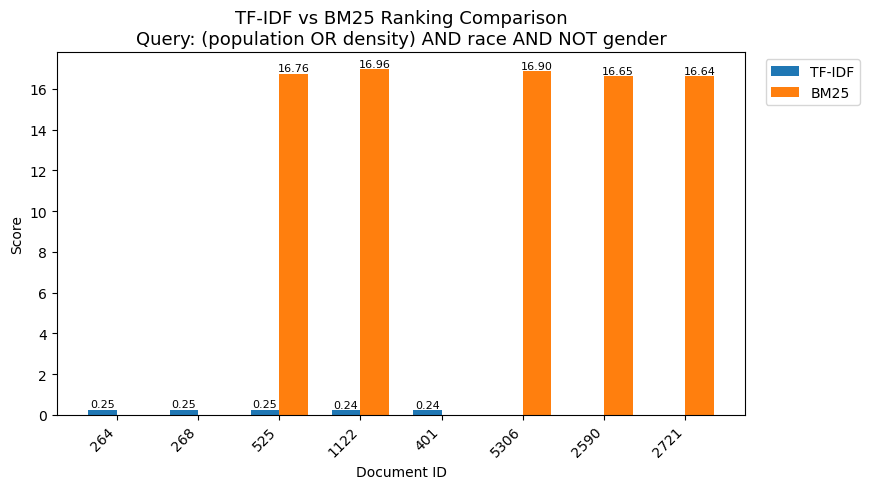

In [68]:
plot_score_comparison(tfidf_top_docs, bm25_top_docs, query=user_query, mode="combined", save_path="results/Combined_comparison.png")

The bar chart illustrates a comparison of the scores given by the **`TF-IDF`** and **`BM25`** algorithms for the top several documents under the query:

> **`(population OR density) AND race AND NOT gender`**

It is evident that **`BM25` generally provides higher scores**, reflecting its **superior modeling** of:

- **term frequency**

- **document length normalization**

Moreover, **some documents are retrieved only by one of the methods**, indicating **differences in relevance judgments** between the two algorithms.

> **Overall, BM25 demonstrates stronger discriminative power and sorting stability** when handling **complex Boolean logic queries**.

### 5.1 Intersection comparison

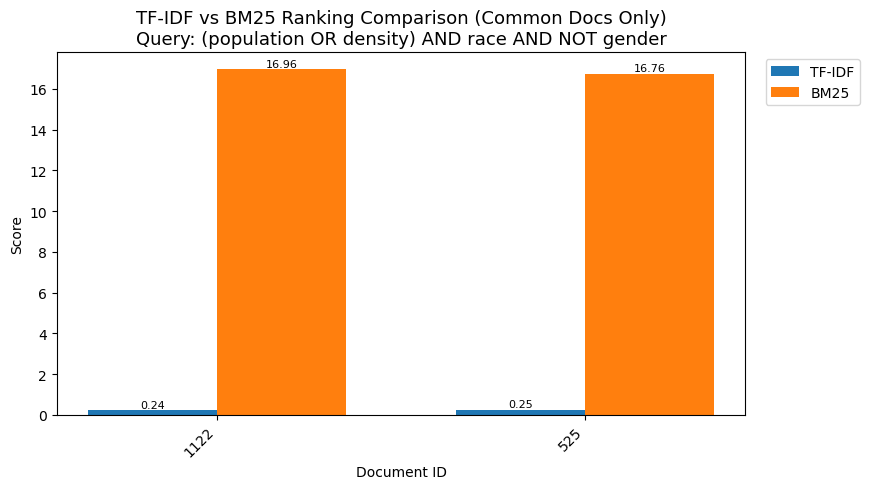

In [69]:
plot_score_comparison(tfidf_top_docs, bm25_top_docs, query=user_query, mode="intersection", save_path="results/Intersection_comparison.png")

The figure displays a comparison of the scores assigned by **`TF-IDF`** and **`BM25`** for the **shared retrieved documents** under the query:

> **`(population OR density) AND race AND NOT gender`**

It is observed that **`BM25` scores significantly higher** than `TF-IDF`, with a **consistent difference**, indicating that:

- **BM25** better accounts for factors such as:

  - **term frequency**

  - **document length**

leading to **more accurate relevance modeling**.

In contrast, `TF-IDF` scores are generally **lower** and **lack discriminative power**.

> **This discrepancy highlights the advantage of BM25 in handling the semantics of complex queries.**


## The End

Appenxid

this cell is for check

In [70]:
# Development code for checking that the results are correct
def check_term_in_doc(doc_id_input, term, doc_dict):
    """
    Checks if a term appears in a given document (case insensitive)
    Parameters:
    @doc_id_input: user input document ID (string or integer)
    @term: query term
    @oc_dict: doc_id -> raw text Mapping
    """
    str_doc_id = str(doc_id_input)
    int_doc_id = None
    try:
        int_doc_id = int(doc_id_input)
    except:
        pass

    if str_doc_id in doc_dict:
        content = doc_dict[str_doc_id]
    elif int_doc_id is not None and int_doc_id in doc_dict:
        content = doc_dict[int_doc_id]
    else:
        print(f"❌ Doc {doc_id_input} non-existent.")
        return

    tokens = preprocess(content)

    if term.lower() in tokens:
        print(f"✅ word '{term}' in doc {doc_id_input} 中。")
    else:
        print(f"❌ word'{term}' **not** Appears in the document {doc_id_input}.")


while True:
    doc_id_input = input("input doc ID:")
    if doc_id_input == "exit()":
        break
    term_input = input("input word:")

    check_term_in_doc(doc_id_input, term_input, doc_dict)


❌ word'gender' **not** Appears in the document 264.
❌ word'gender' **not** Appears in the document 1122.
❌ word'ender' **not** Appears in the document 2721.
